In [2]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import torch

from gsnn.models.GSNN import GSNN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.simulate import simulate

from gsnn.interpret.extract_entity_function import extract_entity_function

%load_ext autoreload
%autoreload 2

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

# Simulating structured data 

To demonstrate how the GSNN operates, and some simple capabilities, we have written a simple bayesian network simulator. We will start by defining a simple toy graph with three inputs and three outputs. 

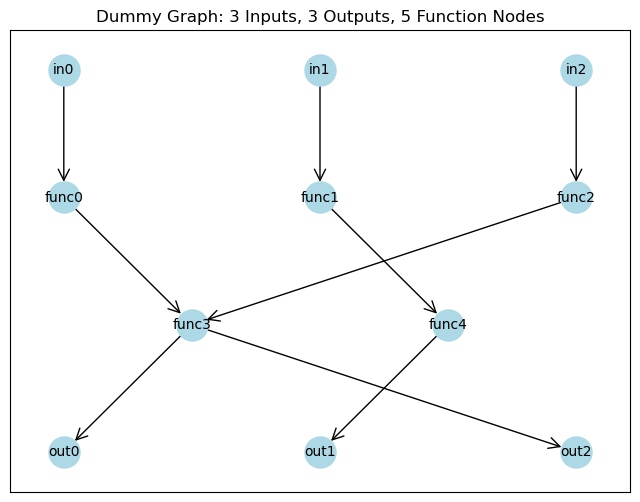

In [3]:
# Create a simple directed graph with 3 inputs, 3 outputs, and 5 function nodes
G = nx.DiGraph()

# Add input nodes, function nodes, and output nodes
input_nodes = ['in0', 'in1', 'in2']
function_nodes = ['func0', 'func1', 'func2', 'func3', 'func4']
output_nodes = ['out0', 'out1', 'out2']

# Add edges from input nodes to function nodes
G.add_edges_from([('in0', 'func0'), ('in1', 'func1'), ('in2', 'func2')])

# Add edges between function nodes
G.add_edges_from([('func0', 'func3'), ('func1', 'func4'), ('func2', 'func3')])

# Add edges from function nodes to output nodes
G.add_edges_from([('func3', 'out0'), ('func4', 'out1'), ('func3', 'out2')])

# Define positions for each node for plotting
pos = {
    'in0': (-2, 2), 'in1': (0, 2), 'in2': (2, 2),
    'func0': (-2, 1), 'func1': (0, 1), 'func2': (2, 1),
    'func3': (-1, 0), 'func4': (1, 0),
    'out0': (-2, -1), 'out1': (0, -1), 'out2': (2, -1)
}

# Plot the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

# Including `special functions` to add complexity 

To simulate more complex functions, we can add specific function behaviors to our network by passing the `special_functions` dict to `simulate`. This enables us to add non-linear node functions to the graph. For instance, in the example below, `func2` will exponentiate the inputs. 

The `simulate` function uses [pyro](https://pyro.ai/) to create a bayesian network that emualtes our graph structure. For our application, each node is modeled as a univariate standard normal distribution where the scale and location of each node is dependant on the values of the preceding nodes. 

NOTE: Using bayesian networks requires that no cycles exists in the graph. Notably, the GSNN can handle cycles and we plan to add more complex simulations that can create these behaviors (i.e., ODE simulations)

In [4]:
special_functions = {'func1': lambda x: -np.mean(x), 'func2':lambda x: np.sum([np.exp(xx) for xx in x]), 
                     'func0': lambda x: np.mean(([(xx)**2 for xx in x])), 'func3': lambda x: -np.mean(x) if all([xx > 0 for xx in x]) else np.mean(x)}

x_train, x_test, y_train, y_test = simulate(G, n_train=1000, n_test=0, input_nodes=input_nodes, output_nodes=output_nodes, 
                                            special_functions=special_functions)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

y_mu = y_train.mean(0); y_std = y_train.std(0)
y_train = (y_train - y_mu)/(y_std + 1e-8)


# Train a GSNN model 

We can train a GSNN model using our synthetic data. Note that we have chosen the hyperparameters to demonstrate some of the inner workings of the GSNN, however, changing these hyperparameters can muddy the interpretation. 

Rationale for hyperparameters:   
> channels (20): Arbitrary; large enough to learn each special function easily.   

> layers (2): minimum path length required to predict outcomes.   

> share_layers (False): To demonstrate the behavior of the GSNN   

> add_function_self_edges (False): adding self edges would complicate function interpretation (each node would have extra input)  

> norm ('none'): for a simple network without cycles, layer norm is not usually needed   

 
Note, we incldued a strong `weight decay` to remove spurrious behaviors and make interpretation simpler. 

In [13]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes)

model = GSNN(data.edge_index_dict,
             data.node_names_dict, 
             channels=20, 
             layers=2,
             share_layers=False, 
             bias=True,
             add_function_self_edges=False,
             norm='none', 
             dropout=0,
             dropout_type='channel').to(device)

print('n params', sum([p.numel() for p in model.parameters()]))

optim = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-3)
crit = torch.nn.MSELoss()

losses_gsnn = []
for i in range(500): 
    optim.zero_grad() 

    yhat = model(x_train)
    loss = crit(y_train, yhat)
    loss.backward() 
    optim.step()

    print(f'iter: {i} | loss: {loss.item():.3f}',end='\r')

n params 529


KeyboardInterrupt: 

# Interpreting learned functions 

We can also extract individual function nodes and evaluate their learned behavior. Note, for simplicity, we have excluded `func3` in the plots as there are multiple inputs, outputs and interpretation requires more complex methods (SHAP, LIME, PDPs, etc.) 

Note that nodes that the layer that is learned is dependent on the nodes location in the graph. For instance, `func0` learns the correct function for layer 0 but not layer 1 because layer 1 has no impact on the outcomes (since we are only using `layers=2`). 

## Interpretation limitations

In most scenarios, we do not know the exact required path length and want to use more competive architectures that make interpretation of individual function nodes more complicated. For instance, if we use a greater number of layers, then many layers may contribute to the prediction of an outcome, so the true effect a function node is an aggregate of many layers behaviors. 

Additionally, in a "chain" of latent functions, the specific functions may be shuffled or aggregated. For instance, in our example `func1` and `func4` may be switched but would still have optimal performance. In more complex networks with a greater number of outputs, this behavior is liable to  converge to more accurate function specific representations. **This explains why we may see "inverted" functions in the interpretations below**

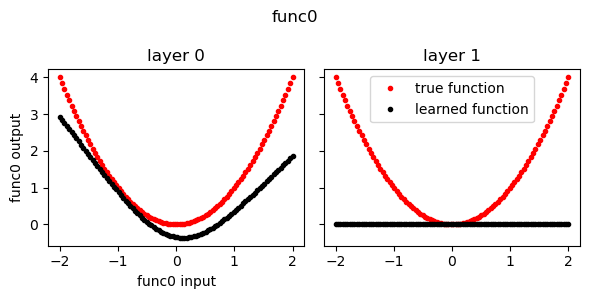

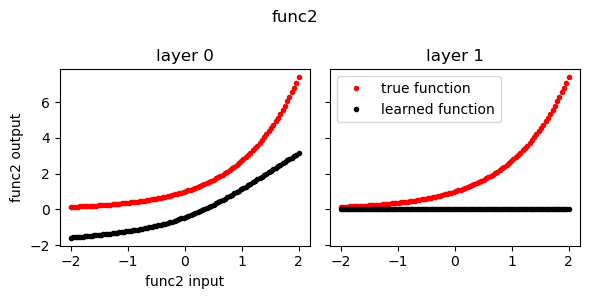

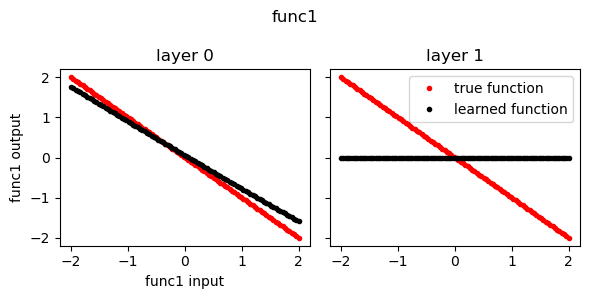

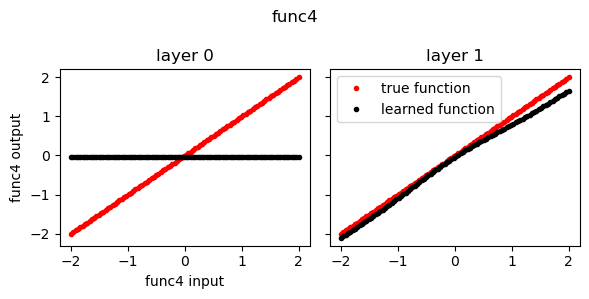

In [5]:
for fn in ['func0', 'func2', 'func1', 'func4']: 

    model = model.eval()

    inp = torch.linspace(-2,2,100).view(-1,1)

    if fn in special_functions: 
        out_true = [special_functions[fn](np.array(x)) for x in inp]
    else: 
        out_true = [x for x in inp]

    f,axes = plt.subplots(1,2, figsize=(6,3), sharey=True)
    plt.suptitle( fn)

    for i in range(2): 
        axes[i].set_title(f'layer {i}')
        func, meta = extract_entity_function(node=fn, model=model, data=data, layer=i)
        out = func(inp)
        axes.flat[i].plot(inp, out_true, 'r.', label='true function')
        axes.flat[i].plot(inp.detach().cpu().numpy().ravel(), out.detach().cpu().numpy().ravel(), 'k.', label='learned function')

    axes[0].set_xlabel(f'{fn} input')
    axes[0].set_ylabel(f'{fn} output')
    plt.tight_layout()
    plt.legend()
    plt.show()